## Regression

In [1]:
#loading_required_packages

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso,LassoLarsCV
import pickle
from tpot.builtins import StackingEstimator
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#importing data
raw_df = pd.read_csv('mean_zero_imputed.csv')

#Label encoding categorical features
cat_cols = raw_df.select_dtypes(include='object').columns
cat_indices = []
for col in cat_cols:
    cat_indices.append(raw_df.columns.get_loc(col))
    

    
#Label encoding cat columns
raw_labeled = raw_df
raw_labeled[cat_cols] = raw_df[cat_cols].apply(LabelEncoder().fit_transform)

**Helper function to give the metrics**

In [4]:
#helper method
def reg_metrics(y_test,preds):
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print('RMSE:',rmse)
    return rmse

### Test and train data

In [5]:
with open('test_index_list.pkl', 'rb') as f:
    test_indices = pickle.load(f)

test_df = raw_df.iloc[test_indices]
X_test_df = test_df.drop(['cuid','convert_30','revenue_30'],axis=1)
y_test_df_con = test_df.convert_30
y_test_df_rev = test_df.revenue_30

In [6]:
raw_index = list(raw_df.index)
for x in test_indices:
    raw_index.remove(x)
    
train_df = raw_df.iloc[raw_index]
X_train_df = train_df.drop(['cuid','convert_30','revenue_30'],axis=1)
y_train_df_con = train_df.convert_30
y_train_df_rev = train_df.revenue_30

### Filtering data where revenue is not zero

In [7]:
train_rev = train_df[train_df.revenue_30!=0.0]
X_train_rev = train_rev.drop(['cuid','convert_30','revenue_30'],axis=1)
y_train_rev = train_rev.revenue_30

test_rev = test_df[test_df.revenue_30!=0.0]
X_test_rev = test_rev.drop(['cuid','convert_30','revenue_30'],axis=1)
y_test_rev = test_rev.revenue_30

In [8]:
#log1p of target
y_train_rev_log = np.log1p(y_train_rev)

**Stacking Estimator with LassoLarsCv and LGBMRegressor**

In [9]:
reg_pipe = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=False)),
    LGBMRegressor())

reg_pipe.fit(X_train_rev,y_train_rev_log)
preds_e = reg_pipe.predict(X_test_rev)
preds_e = np.expm1(preds_e)
reg_metrics(y_test_rev,preds_e)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RMSE: 1062.460007194682


1062.460007194682

In [10]:
filename = 'reg_stacked.pkl'
pickle.dump(reg_pipe, open(filename, 'wb'))

loaded_reg = pickle.load(open(filename, 'rb'))

In [11]:
preds_e = loaded_reg.predict(X_test_rev)
preds_e = np.expm1(preds_e)
reg_metrics(y_test_rev,preds_e)

RMSE: 1062.460007194682


1062.460007194682

**Model**

In [12]:
(reg_pipe.get_params)

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('stackingestimator',
                 StackingEstimator(estimator=LassoLarsCV(copy_X=True, cv='warn',
                                                         eps=2.220446049250313e-16,
                                                         fit_intercept=True,
                                                         max_iter=500,
                                                         max_n_alphas=1000,
                                                         n_jobs=None,
                                                         normalize=False,
                                                         positive=False,
                                                         precompute='auto',
                                                         verbose=False))),
                ('lgbmregressor',
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample

### Predictions on whole test set instead of just for +ve revenue

In [13]:
pred_on_whole = reg_pipe.predict(X_test_df)
pred_on_whole = np.expm1(pred_on_whole)


reg_metrics(y_test_df_rev,pred_on_whole)

RMSE: 523.2583969151068


523.2583969151068

### Further reducing the rmse

Using the classifier to first predict the classes and then doing the predictions only where convert_30=1

In [17]:
#helper function
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,confusion_matrix,roc_curve

def report(y_true,y_preds):
    print(classification_report(y_true,y_preds))
    print("*"*10+"Confusion Matrix"+"*"*10+'\n',confusion_matrix(y_true,y_preds))
    print("AUC_ROC:",roc_auc_score(y_true,y_preds))
    print("accuracy:",accuracy_score(y_true,y_preds))

In [18]:
to_drop = ['dayssincelastord',
 'cuidshare',
 'numstores',
 'avgnps',
 'maxnps',
 'numvisittotal',
 'numskusviewedone',
 'numskusviewedthreeone',
 'numskusviewedseventhree',
 'numskusviewedthirtyseven',
 'numskusviewedsixtythirty',
 'numskusviewedyearsixty']

Loading the saved models and predicting class for the test set

In [27]:
filename = 'xg_corr_auc0.723acc0.765.pkl'
loaded_xgbc = pickle.load(open(filename, 'rb'))
preds_xg_proba = loaded_xgbc.predict_proba(X_test_df.drop(to_drop,axis=1))
preds_xg = np.where(preds_xg_proba[:,1]>0.5,1,0)

filename = 'lgbm_corr_auc0.725acc0.767.pkl'
lgbmc_model = pickle.load(open(filename, 'rb'))
preds_lgbm_proba = lgbmc_model.predict_proba(X_test_df.drop(to_drop,axis=1))
preds_lgbm = np.where(preds_lgbm_proba[:,1]>0.5,1,0)



preds3_proba = ((preds_lgbm_proba*0.63+preds_xg_proba*0.37)[:,1])

preds3 = np.where(preds3_proba>0.5,1,0)

Creating a dataframe with predicted and converted classes, revenue

In [23]:
conv_original = np.array(y_test_df_con)
conv_predicted = np.array(preds3)
rev_original = np.array(y_test_df_rev)
revenue_predicted = np.array(pred_on_whole)

In [26]:
org_pred_df = pd.DataFrame({'conv_original':conv_original, 'conv_predicted':conv_predicted,
                            'rev_original':rev_original,'revenue_predicted':revenue_predicted})

conditions = [
    org_pred_df['conv_predicted'] ==0,
    org_pred_df['conv_predicted'] !=0
]


outputs = [0,np.NAN]

res = np.select(conditions, outputs, 'Other')
org_pred_df['adjusted_rev'] = res

org_pred_df=org_pred_df.replace('nan',np.NaN)
org_pred_df.isnull().sum()

org_pred_df['adjusted_rev'] = org_pred_df['adjusted_rev'].fillna(org_pred_df['revenue_predicted'])

reg_metrics(org_pred_df.rev_original,org_pred_df.adjusted_rev)


RMSE: 417.9475301321053


417.9475301321053

### True vs predicted

Text(0,0.5,'Predicted')

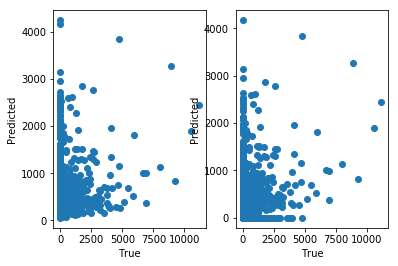

In [46]:
plt.subplot(1,2,1)
plt.scatter(y_test_df_rev,pred_on_whole)
plt.xlabel('True')
plt.ylabel('Predicted')

plt.subplot(1,2,2)
plt.scatter(org_pred_df.rev_original,org_pred_df.adjusted_rev.astype(int))
plt.xlabel('True')
plt.ylabel('Predicted')

* RMSE of 523.2583 was achieved by stacking LassoLarsCv and LGBMRegressor
* RMSE was further reduced to 417.94 by replacing revenue with zero where predicted convert_30 is zero
    * Model is good at predicting small and medium range values but when it comes to values greater than 1000 model fails to predict. Reason is that we don't have much data for extreme values.
* Also most of the zeros were predicted wrongly because our classifier is not much accurate.